# Calibrating Traditional Methods

In this notebook, we show how to calibrate a $\mathcal{J}$-invariant denoiser, and compare its performance
with the original denoiser.

In [66]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import sys
sys.path.append("..")

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise

In [69]:
#from skimage.measure import compare_ssim as ssim
#from skimage.measure import compare_psnr as psnr
#from skimage.measure import compare_mse as mse
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

from util import plot_grid, plot_images, expand

In [70]:
plt.rc('figure', figsize = (5,5))

In [71]:
show = lambda x: plt.imshow(x, cmap=plt.cm.gray)

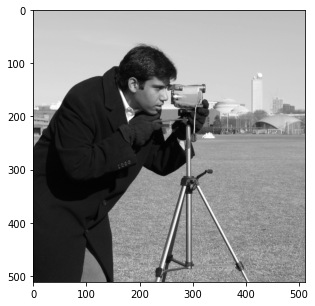

In [72]:
image = data.camera()
show(image)

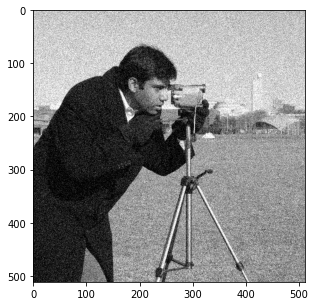

In [73]:
np.random.seed(3)
noisy_image = img_as_ubyte(random_noise(image, mode = 'gaussian', var=0.01))
show(noisy_image)

We begin by comparing an ordinary median filter to a "donut" median filter, with the center removed.

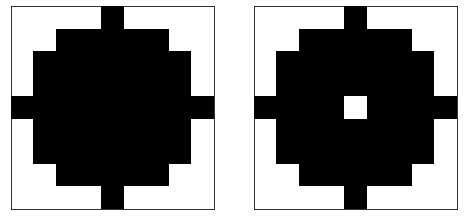

In [74]:
def mask_center(x):
    x[len(x)//2,len(x)//2] = 0
    return x
plot_images([1-disk(4), 1-mask_center(disk(4))])

In [75]:
cm = plt.get_cmap("tab10")
orange_regular_disk = (1 - disk(4))[:,:,np.newaxis] + (disk(4))[:,:,np.newaxis]*np.array(cm(1)[:-1])[np.newaxis, np.newaxis]
blue_donut_disk = (1 - mask_center(disk(4)))[:,:,np.newaxis] + (mask_center(disk(4)))[:,:,np.newaxis]*np.array(cm(0)[:-1])[np.newaxis, np.newaxis]

In [76]:
#plt.imsave ( dir + "regular_disk.png", expand(orange_regular_disk, 5))
#plt.imsave ( dir + "donut_disk.png", expand(blue_donut_disk, 5))

In [77]:
plt.imsave ( 'D:/noise2self-master/noise2self-master/ddiirr' + "regular_disk.png", expand(orange_regular_disk, 5))
plt.imsave ( 'D:/noise2self-master/noise2self-master/ddiirr'+ 'donut_disk.png', expand(blue_donut_disk, 5))

In [78]:
radii = range(1, 7)
mask_med = np.array([median(noisy_image, mask_center(disk(i))) for i in radii])
med = np.array([median(noisy_image, disk(i)) for i in radii])

In [79]:
def stats(im_list, noisy_img, img):
    img = img_as_float(img)
    noisy_img = img_as_float(noisy_img)
    im_list = [img_as_float(x) for x in im_list]
    
    loss = [mse(x, noisy_img) for x in im_list]
    mse_gt = [mse(x, img) for x in im_list]
    psnr_gt = [psnr(x, img) for x in im_list]
    
    return loss, mse_gt, psnr_gt

In [80]:
loss_med, mse_med, psnr_med = stats(med, noisy_image, image)
loss_mask_med, mse_mask_med, psnr_mask_med = stats(mask_med, noisy_image, image)

In [81]:
opt = radii[np.argmin(loss_mask_med)]
print(opt)

3


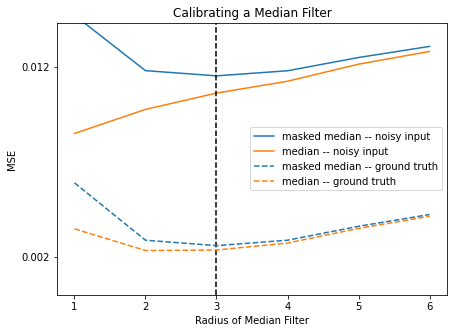

In [82]:
plt.figure(figsize=(7,5))

plt.plot(radii, loss_mask_med, label = 'masked median -- noisy input', color = 'C0')
plt.plot(radii, loss_med, label = 'median -- noisy input', color = 'C1')

plt.axvline(radii[np.argmin(loss_mask_med)], color='k', linestyle='--')
plt.title('Calibrating a Median Filter')

plt.plot(radii, mse_mask_med, label = 'masked median -- ground truth', color = 'C0', linestyle='--')
plt.plot(radii, mse_med, label = 'median -- ground truth', color = 'C1', linestyle='--')
plt.ylabel('MSE')
plt.xlabel('Radius of Median Filter')

plt.yticks([0.002, 0.012])
plt.ylim(0, 0.0143)
plt.legend(loc='center right')

plt.savefig('D:/noise2self-master/noise2self-master/ddiirr' + 'median_filter.pdf')

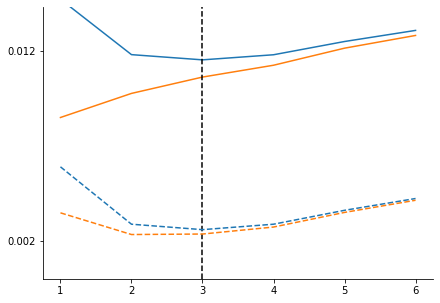

In [83]:
plt.figure(figsize=(7,5))

plt.plot(radii, loss_mask_med, label = 'masked median -- noisy input', color = 'C0')
plt.plot(radii, loss_med, label = 'median -- noisy input', color = 'C1')

plt.axvline(radii[np.argmin(loss_mask_med)], color='k', linestyle='--')

plt.plot(radii, mse_mask_med, label = 'masked median -- ground truth', color = 'C0', linestyle='--')
plt.plot(radii, mse_med, label = 'median -- ground truth', color = 'C1', linestyle='--')

plt.yticks([0.002, 0.012])
plt.ylim(0, 0.0143)

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.savefig('D:/noise2self-master/noise2self-master/ddiirr' + 'median_filter_bare.pdf')

In [84]:
inset_x_min = 100
inset_x_max = 160
inset_y_min = 230
inset_y_max = 290

get_inset = lambda x: x[inset_x_min:inset_x_max, inset_y_min:inset_y_max]

plt.imsave('D:/noise2self-master/noise2self-master/ddiirr' + 'camera_noisy.png', get_inset(noisy_image), cmap = 'Greys_r')
plt.imsave('D:/noise2self-master/noise2self-master/ddiirr' + 'camera_clean.png', get_inset(image), cmap = 'Greys_r')
for i in range(len(mask_med)):
    plt.imsave('D:/noise2self-master/noise2self-master/ddiirr' + 'camera_median_' + str(radii[i]) + '.png', get_inset(mask_med[i]), cmap = 'Greys_r')

# Conversion to J-invariance

Let $f$ be a classical denoiser, and consider some partition $\mathcal{J}$ of the pixels. Let $s(x)$ be the 
function replacing each pixel with the average of its neighbors. Then the function $g$ defined by

$g(x)_J := f_\theta(\mathbf{1}_{J}\cdot s(x) + \mathbf{1}_{J^c}\cdot x)_J,$

will be $J$-invariant for each $J \in \mathcal{J}$.

Below, we implement this in a functional way: given a denoiser, the `invariant_denoise` is the appropriate invariant denoiser.

In [85]:
from scipy.signal import convolve2d
def interpolate_image(x, conv_filter=None):
    if conv_filter is None:
        conv_filter = np.array([[0, 0.25, 0], [0.25, 0, 0.25], [0, 0.25, 0]])
    return convolve2d(x, conv_filter, mode = 'same')
def generate_mask(shape, idx, width=3):
    m = np.zeros(shape)
    
    phasex = idx % width
    phasey = (idx // width) % width
    
    m[phasex::width, phasey::width] = 1
    return m
def invariant_denoise(img, width, denoiser):
    
    n_masks = width*width
    
    interp = interpolate_image(img)
    
    output = np.zeros(img.shape)
    
    for i in range(n_masks):
        m = generate_mask(img.shape, i, width=width)
        input_image = m*interp + (1 - m)*img
        input_image = input_image.astype(img.dtype)
        output += m*denoiser(input_image)
    return output

## Wavelet

In [86]:
from skimage.restoration import denoise_wavelet

In [87]:
sigma_range = np.arange(0.08, 0.3, 0.03)

In [88]:
reconstructions = [denoise_wavelet(noisy_image, sigma = sigma, mode='hard', multichannel = False)
                   for sigma in sigma_range]

C:\Users\GDL\AppData\Local\Temp\ipykernel_20940\1314419847.py:1: FutureWarning: `multichannel` is a deprecated argument name for `denoise_wavelet`. It will be removed in version 1.0. Please use `channel_axis` instead.
  reconstructions = [denoise_wavelet(noisy_image, sigma = sigma, mode='hard', multichannel = False)


In [91]:
reconstructions_mask = [reconstruct(noisy_image, 4, lambda x: 
                                    denoise_wavelet(x, sigma = sigma, mode='hard', multichannel = False))
                   for sigma in sigma_range]

TypeError: 'list' object is not callable

In [89]:
#reconstructions_mask = [reconstruct(noisy_image, 4, lambda x: 
                                    denoise_wavelet(x, sigma = sigma, mode='hard', multichannel = False))
                   for sigma in sigma_range]

NameError: name 'reconstruct' is not defined

In [ ]:
loss_wavelet, mse_wavelet, psnr_wavelet = stats(reconstructions, noisy_image, image)
loss_mask_wavelet, mse_mask_wavelet, psnr_mask_wavelet = stats(reconstructions_mask, noisy_image, image)

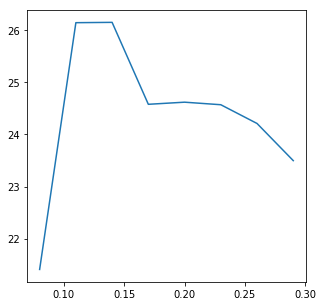

In [ ]:
plt.plot(sigma_range, psnr_wavelet)

In [ ]:
opt = sigma_range[np.argmin(loss_mask_wavelet)]

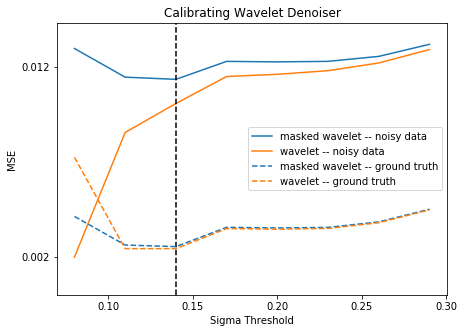

In [ ]:
plt.figure(figsize=(7,5))

plt.plot(sigma_range, loss_mask_wavelet, label = 'masked wavelet -- noisy data', color = 'C0')
plt.plot(sigma_range, loss_wavelet, label = 'wavelet -- noisy data', color = 'C1')

plt.axvline(sigma_range[np.argmin(loss_mask_wavelet)], color='k', linestyle='--')
plt.title('Calibrating Wavelet Denoiser')

plt.plot(sigma_range, mse_mask_wavelet, label = 'masked wavelet -- ground truth', color = 'C0', linestyle='--')
plt.plot(sigma_range, mse_wavelet, label = 'wavelet -- ground truth', color = 'C1', linestyle='--')
plt.ylabel('MSE')
plt.xlabel('Sigma Threshold')
plt.yticks([0.002, 0.012])
plt.ylim(0, 0.0143)

plt.legend(loc='center right')

plt.savefig(dir + 'wavelet_filter.pdf')

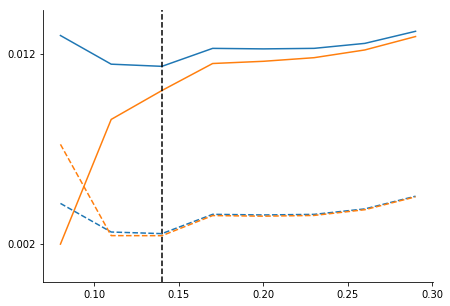

In [ ]:
plt.figure(figsize=(7,5))

plt.plot(sigma_range, loss_mask_wavelet, label = 'masked wavelet -- noisy data', color = 'C0')
plt.plot(sigma_range, loss_wavelet, label = 'wavelet -- noisy data', color = 'C1')

plt.axvline(sigma_range[np.argmin(loss_mask_wavelet)], color='k', linestyle='--')

plt.plot(sigma_range, mse_mask_wavelet, label = 'masked wavelet -- ground truth', color = 'C0', linestyle='--')
plt.plot(sigma_range, mse_wavelet, label = 'wavelet -- ground truth', color = 'C1', linestyle='--')

plt.yticks([0.002, 0.012])
plt.ylim(0, 0.0143)


# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.savefig(dir + 'wavelet_filter_bare.pdf')

### Basic run of NL-Means

## NL-Means

In [ ]:
from skimage.restoration import denoise_nl_means, estimate_sigma

sigma_est = np.mean(estimate_sigma(noisy_image, multichannel=False))
print(sigma_est/255)

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

h_suggested = 0.8 * sigma_est

denoise_fast = denoise_nl_means(noisy_image, h=h_suggested, fast_mode=True,
                                **patch_kw)
psnr(denoise_fast.astype(np.uint8), image)

0.0930814453935413


28.942262005433406

In [ ]:
h_range = sigma_est*np.arange(0.5, 2.0, 0.2)

In [ ]:
reconstructions_nl = [denoise_nl_means(noisy_image, h=h, fast_mode=True,
                                **patch_kw)/255 for h in h_range]

reconstructions_nl_mask = [reconstruct(noisy_image, 4, lambda x: denoise_nl_means(x, h=h, fast_mode=True,
                                **patch_kw))/255 for h in h_range]

In [ ]:
loss_nl, mse_nl, psnr_nl = stats(reconstructions_nl, noisy_image, image)
loss_mask_nl, mse_mask_nl, psnr_mask_nl = stats(reconstructions_nl_mask, noisy_image, image)

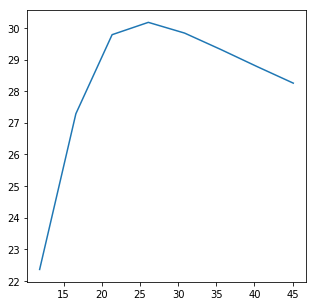

In [ ]:
plt.plot(h_range, psnr_nl)

In [ ]:
opt = sigma_range[np.argmin(loss_mask_nl)]

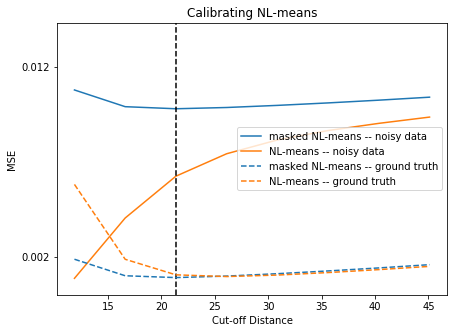

In [ ]:
plt.figure(figsize=(7,5))

plt.plot(h_range, loss_mask_nl, label = 'masked NL-means -- noisy data', color = 'C0')
plt.plot(h_range, loss_nl, label = 'NL-means -- noisy data', color = 'C1')

plt.axvline(h_range[np.argmin(loss_mask_nl)], color='k', linestyle='--')
plt.title('Calibrating NL-means')

plt.plot(h_range, mse_mask_nl, label = 'masked NL-means -- ground truth', color = 'C0', linestyle='--')
plt.plot(h_range, mse_nl, label = 'NL-means -- ground truth', color = 'C1', linestyle='--')
plt.ylabel('MSE')
plt.xlabel('Cut-off Distance')

plt.legend(loc='center right')
plt.yticks([0.002, 0.012])
plt.ylim(0, 0.0143)

plt.savefig(dir + 'nl-means_filter.pdf')

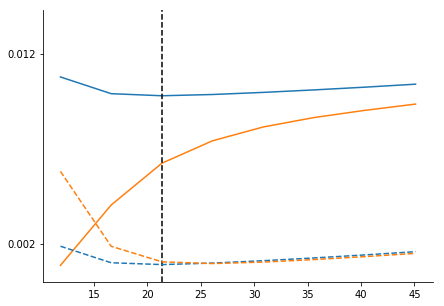

In [ ]:
plt.figure(figsize=(7,5))

plt.plot(h_range, loss_mask_nl, label = 'masked NL-means -- noisy data', color = 'C0')
plt.plot(h_range, loss_nl, label = 'NL-means -- noisy data', color = 'C1')

plt.axvline(h_range[np.argmin(loss_mask_nl)], color='k', linestyle='--')

plt.plot(h_range, mse_mask_nl, label = 'masked NL-means -- ground truth', color = 'C0', linestyle='--')
plt.plot(h_range, mse_nl, label = 'NL-means -- ground truth', color = 'C1', linestyle='--')

plt.yticks([0.002, 0.012])
plt.ylim(0, 0.0143)


# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.savefig(dir + 'nl-means_filter_bare.pdf')

# Which method is best?

In [ ]:
min(loss_mask_nl), min(loss_mask_wavelet), min(loss_mask_med)

(0.009788272253672988, 0.011335747034270325, 0.010729704918837556)

In [ ]:
min(mse_mask_nl), min(mse_mask_wavelet), min(mse_mask_med)

(0.000905122289523651, 0.002534390855976229, 0.0017931402045825223)

In [ ]:
max(psnr_mask_nl), max(psnr_mask_wavelet), max(psnr_mask_med)

(30.432927400463143, 25.961264070122503, 27.463857518789855)

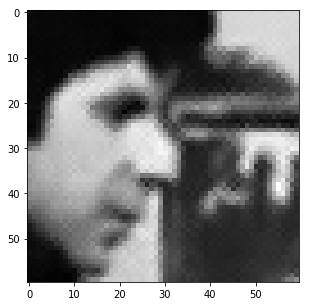

In [ ]:
show(get_inset(reconstructions_nl_mask[np.argmin(loss_mask_nl)]))

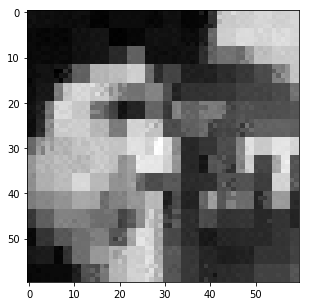

In [ ]:
show(get_inset(reconstructions_mask[np.argmin(loss_mask_wavelet)]))

## Shrinkage

Given two uncorrelated and unbiased estimators $u$ and $v$ of some quantity $y$, we may form a linear combination:
    
$\lambda u + (1 - \lambda)v.$

The variance of this estimator is

$\lambda^2 U + (1 - \lambda)^2 V,$

where $U$ and $V$ are the variances of $u$ and $v$ respectively. This expression is minimized at

$\lambda = V/(U + V).$

The variance of the result is $UV/(U+V) = V\frac{1}{1+V/U}$. When $V$ is the term with lowest variance, here we can lower it by an amount depending on $V/U$. When the variance of $v$ is much lower than that of $u$, we just get $V$ out, but when they are the same our variance is exactly halved. Note that this is monotonic in $V$, so when comparing methods, mixing in the original signal will not change their order. In terms of PSNR, the new value is

$10*\log_{10}(\frac{1+V/U}{V}) = \operatorname{PSNR}(V) + 10*\log_{10}(1 + V/U) \approx \operatorname{PSNR}(V) + 10/\log_{10}(e) (\frac{V}{U} - \frac{1}{2}(\frac{V}{U})^2) = \operatorname{PSNR}(V) + 4.34 \frac{V}{U}$

If we fix $y$, then $x_j$ and $\mathbb{E} y_j|x_{-j}$ are both independent estimators of $y_j$, so the above reasoning applies. Note that the loss is the variance of $x_j|x_{-j}$, whose two components are the variance of $x_j|y_j$ and the variance of $y_j|x_{-j}$.

If we know the distribution of the noise, ie, we know the variance of $x_j|y_j$, then we can compute the variance of $y_j|x_{-j}$ by subtracting it from the variance of $x_j|x_{-j}$, aka, from the value of the loss. That will provide us with the optimal $\lambda$ to use.

In [ ]:
log10 x = log e x / log e 10

SyntaxError: invalid syntax (<ipython-input-93-c06b7d2b752e>, line 1)

In [ ]:
image_float = img_as_float(image)
noisy_image_float = img_as_float(noisy_image)

In [ ]:
noise_var = mse(noisy_image_float, image_float)

In [ ]:
idx = np.argmin(loss_mask_wavelet)
y_pred = reconstructions_mask[idx]
total_var = loss_mask_wavelet[idx]

In [ ]:
idx = np.argmin(loss_mask_nl)
y_pred = reconstructions_nl_mask[idx]
total_var = loss_mask_nl[idx]

In [ ]:
idx = np.argmin(loss_mask_med)
y_pred = img_as_float(med[idx])
total_var = loss_mask_med[idx]

In [ ]:
for mode, recons, loss in [('median', mask_med, loss_mask_med),
                           ('wavelet', reconstructions_mask, loss_mask_wavelet),
                           ('nl_means', reconstructions_nl_mask, loss_mask_nl)]:

    print("mode: ", mode)
    idx = np.argmin(loss)
    y_pred = img_as_float(recons[idx])
    total_var = loss[idx]

    lam = noise_var/total_var
    improved_prediction = lam*y_pred + (1 - lam)*noisy_image_float
    print("Lambda weighting: ", np.round(lam, 2))
    print("Approx change in PSNR: ", np.round(4.34*(total_var - noise_var)/noise_var, 2))
    print("Loss: ", total_var.round(4))
    print("Original PSNR: ", psnr(y_pred, image_float).round(1))
    print("New PSNR: ", psnr(improved_prediction, image_float).round(1))
    print('---------------')

In [ ]:
4.34*(total_var - noise_var)/noise_var

In [ ]:
psnr(noisy_image_float, image_float), psnr(y_pred, image_float), psnr(improved_prediction, image_float)

In [ ]:
plot_images([get_inset(noisy_image),
             get_inset(y_pred), 
             get_inset(improved_prediction),
             get_inset(image)])

In [ ]:
ssim(noisy_image_float, image_float), ssim(y_pred, image_float), ssim(improved_prediction, image_float)